## Model Based Collaborative Filtering

### Package download
- [Scikit-surprise](https://github.com/NicolasHug/Surprise/tree/fa7455880192383f01475162b4cbd310d91d29ca) package

In [1]:
!pip install numpy
!pip install scipy
!pip install pandas
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 4.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619416 sha256=19b5dabedbdd021df5b7854a4957bd950e1608401620141d91568d92c28daa02
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import os
import sys

import numpy as np
import pandas as pd

### Dataset download and preprocessing

- [MovieLens 1m Dataset](https://grouplens.org/datasets/movielens/)


In [26]:
# data_pth = "drive/MyDrive/GaTech/big_data/ml-100k/"
data_pth = "drive/MyDrive/GaTech/big_data/ml-1m/"
ratings_df = pd.read_csv(os.path.join(data_pth, "ratings.dat"), delimiter="::", header=None, names=['userId', 'movieId', 'rating', 'timestamp'], usecols=['userId', 'movieId', 'rating'])
movies_df = pd.read_csv(os.path.join(data_pth, "movies.dat"), delimiter="::", header=None, names=['movieId', 'Title', 'Genre'], usecols=['movieId', 'Title'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [105]:
users_df = pd.read_csv(os.path.join(data_pth, "users.dat"), delimiter="::", header=None, names=['userId', 'Gender', 'Age', 'Occupation', 'Zip-code'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [27]:
ratings_df

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [28]:
movies_df

,movieId,Title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3878,3948,Meet the Parents (2000)
3879,3949,Requiem for a Dream (2000)
3880,3950,Tigerland (2000)
3881,3951,Two Family House (2000)


In [106]:
users_df

,userId,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [29]:
clean_ratings_df = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Total number of ratings')

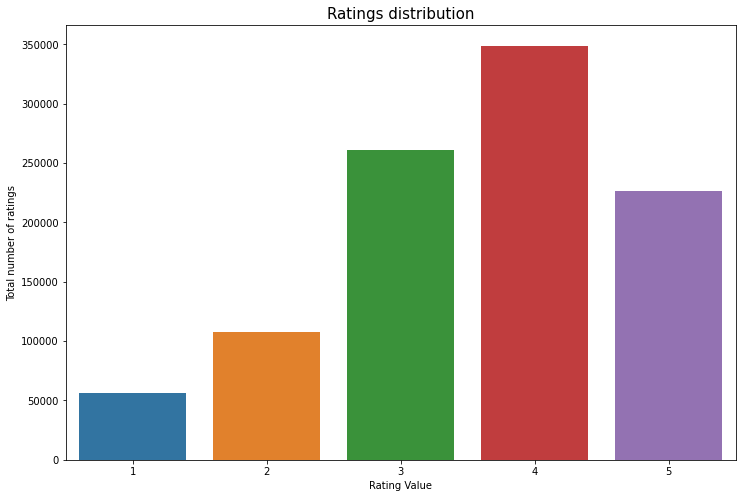

In [115]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Ratings distribution', fontsize=15)
sns.countplot(ratings_df['rating'])
ax.set_xlabel("Rating Value")
ax.set_ylabel("Total number of ratings")

In [30]:
clean_ratings_df

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,4.0,3.0,0.0,4.0,3.0,4.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
clean_ratings_array = clean_ratings_df.to_numpy()

### Apply SVD

In [31]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(clean_ratings_df, k = 50)

sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [32]:
all_user_predicted_ratings

array([[ 4.29255637e+00,  1.64772079e-01, -1.84503665e-01, ...,
         5.15452309e-02,  5.73491658e-02,  7.67433007e-02],
       [ 7.54816503e-01,  1.28980846e-01,  3.41128027e-01, ...,
        -1.06674885e-01, -4.96498072e-02, -1.26564170e-01],
       [ 1.84485846e+00,  4.73855109e-01,  9.85732633e-02, ...,
         3.47831968e-02,  2.93366015e-02, -1.21871216e-01],
       ...,
       [ 6.21009109e-01, -1.68948564e-01,  1.23985224e-01, ...,
        -5.51732363e-04, -2.29912367e-02, -1.15556688e-01],
       [ 1.53096336e+00, -5.79252892e-02, -1.51070902e-01, ...,
         1.72056443e-04, -2.59856159e-02, -1.66850333e-01],
       [ 1.99767681e+00, -1.84038905e-01, -1.47936651e-01, ...,
         2.60835477e-02,  1.55205380e-01,  2.73349288e-01]])

In [48]:
print(all_user_predicted_ratings.shape)
print("Negatives : {}".format(np.sum(np.sum(all_user_predicted_ratings < 0, axis=0))))
print("Total: {}".format(all_user_predicted_ratings.shape[0]*all_user_predicted_ratings.shape[1]))

(6040, 3706)
Negatives : 8693912
Total: 22384240


### Improved Matrix Factorization

#### Load Dataset

In [51]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

data = Dataset.load_builtin("ml-1m")

### Train-test split

In [53]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.20)

### Train the model

In [56]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import time

start_time = time.time()
model = SVD(n_factors=50)

# cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
model.fit(trainset)
end_time = time.time()

print("Time taken to train {}min and {}sec".format((end_time-start_time)/60, (end_time-start_time)%60))

Time taken to train 0.5227950572967529min and 31.367703437805176sec


### Test the model

In [57]:
predictions = model.test(testset)

In [82]:
predictions[:20]

[Prediction(uid='4736', iid='904', r_ui=4.0, est=4.248840358220016, details={'was_impossible': False}),
 Prediction(uid='2627', iid='1844', r_ui=4.0, est=3.3789302410789466, details={'was_impossible': False}),
 Prediction(uid='5805', iid='898', r_ui=5.0, est=4.574129383298508, details={'was_impossible': False}),
 Prediction(uid='954', iid='923', r_ui=5.0, est=3.5658192850493764, details={'was_impossible': False}),
 Prediction(uid='5023', iid='1282', r_ui=5.0, est=3.9506002829958513, details={'was_impossible': False}),
 Prediction(uid='3410', iid='3354', r_ui=2.0, est=1.8321612432762415, details={'was_impossible': False}),
 Prediction(uid='839', iid='2859', r_ui=5.0, est=4.605515992330864, details={'was_impossible': False}),
 Prediction(uid='4055', iid='62', r_ui=3.0, est=3.082628294006105, details={'was_impossible': False}),
 Prediction(uid='1230', iid='3510', r_ui=4.0, est=4.273095188494818, details={'was_impossible': False}),
 Prediction(uid='1835', iid='2381', r_ui=1.0, est=1.966102

### Compute RMSE

In [58]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.8696


0.8696399479007743

### Rating predictions and Top-1 and top-5 recommendations

In [73]:
test_users = [idx[0] for idx in testset[:20]]
preds_top = testset[:20]

In [83]:
print(test_users)
print(preds_top)

['4736', '2627', '5805', '954', '5023', '3410', '839', '4055', '1230', '1835', '5960', '262', '4387', '297', '1922', '482', '4812', '710', '1429', '1980']
[('4736', '904', 4.0), ('2627', '1844', 4.0), ('5805', '898', 5.0), ('954', '923', 5.0), ('5023', '1282', 5.0), ('3410', '3354', 2.0), ('839', '2859', 5.0), ('4055', '62', 3.0), ('1230', '3510', 4.0), ('1835', '2381', 1.0), ('5960', '2506', 5.0), ('262', '1009', 4.0), ('4387', '1259', 5.0), ('297', '1265', 5.0), ('1922', '2110', 3.0), ('482', '2133', 3.0), ('4812', '3265', 5.0), ('710', '3176', 4.0), ('1429', '1593', 2.0), ('1980', '1296', 5.0)]


In [94]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Calculate the top-5 accuracy (1000 examples) 



In [102]:
top_n = get_top_n(predictions[:1000], n=5)

acc_1, acc_5 = [0]*1000, [0]*1000

thresh = 4

# Print the recommended items for each user
for data_idx, (uid, user_ratings) in enumerate(top_n.items()):
    for idx, (_, est, true_r) in enumerate(user_ratings):
        if true_r >= thresh:
            if acc_5[data_idx] == 0:
                acc_5[data_idx] = 1
            if idx == 0 and acc_1[data_idx] == 0:
                acc_1[data_idx] = 1

print("Top-5 accuracy : {} with thresh : {}".format(sum(acc_5), thresh))
print("Top-1 accuracy : {} with thresh : {}".format(sum(acc_1), thresh))

Top-5 accuracy : 522 with thresh : 4
Top-1 accuracy : 505 with thresh : 4


In [34]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
import time

start_time = time.time()
data = Dataset.load_builtin("ml-1m")

param_grid = {
    "n_factors": []
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, verbose=True)

gs.fit(data)
end_time = time.time()

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print("Time taken to train and fine-tune: {}".format(end_time-start_time))

0.9297305084111032
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


### For Dimension size equal to 100

In [104]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import time

start_time = time.time()
model = SVD(n_factors=100)

# cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
model.fit(trainset)
end_time = time.time()

print("Time taken to train {}min and {}sec".format((end_time-start_time)/60, (end_time-start_time)%60))

Time taken to train 0.8148441553115845min and 48.89064931869507sec


### Test the model

In [107]:
predictions = model.test(testset)

In [108]:
predictions[:20]

[Prediction(uid='4736', iid='904', r_ui=4.0, est=4.160363893816728, details={'was_impossible': False}),
 Prediction(uid='2627', iid='1844', r_ui=4.0, est=3.477646168315494, details={'was_impossible': False}),
 Prediction(uid='5805', iid='898', r_ui=5.0, est=4.561142412673522, details={'was_impossible': False}),
 Prediction(uid='954', iid='923', r_ui=5.0, est=3.80373149508904, details={'was_impossible': False}),
 Prediction(uid='5023', iid='1282', r_ui=5.0, est=3.5049939000650223, details={'was_impossible': False}),
 Prediction(uid='3410', iid='3354', r_ui=2.0, est=2.1730989941934644, details={'was_impossible': False}),
 Prediction(uid='839', iid='2859', r_ui=5.0, est=4.544164115209048, details={'was_impossible': False}),
 Prediction(uid='4055', iid='62', r_ui=3.0, est=2.8497574919767996, details={'was_impossible': False}),
 Prediction(uid='1230', iid='3510', r_ui=4.0, est=4.236522592674168, details={'was_impossible': False}),
 Prediction(uid='1835', iid='2381', r_ui=1.0, est=2.25499799

### Compute RMSE

In [109]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.8730


0.8730299377931404

### Rating predictions and Top-1 and top-5 recommendations

In [117]:
test_users = [idx[0] for idx in testset[:20]]
test_movies = [idx[1] for idx in testset[:20]]
preds_top = testset[:20]

In [111]:
print(test_users)
print(preds_top)

['4736', '2627', '5805', '954', '5023', '3410', '839', '4055', '1230', '1835', '5960', '262', '4387', '297', '1922', '482', '4812', '710', '1429', '1980']
[('4736', '904', 4.0), ('2627', '1844', 4.0), ('5805', '898', 5.0), ('954', '923', 5.0), ('5023', '1282', 5.0), ('3410', '3354', 2.0), ('839', '2859', 5.0), ('4055', '62', 3.0), ('1230', '3510', 4.0), ('1835', '2381', 1.0), ('5960', '2506', 5.0), ('262', '1009', 4.0), ('4387', '1259', 5.0), ('297', '1265', 5.0), ('1922', '2110', 3.0), ('482', '2133', 3.0), ('4812', '3265', 5.0), ('710', '3176', 4.0), ('1429', '1593', 2.0), ('1980', '1296', 5.0)]


In [124]:
movies_df[movies_df["movieId"].apply(lambda x: str(x) in test_movies)]
# movies_df["movieId"].tolist()

,movieId,Title
61,62,Mr. Holland's Opus (1995)
886,898,"Philadelphia Story, The (1940)"
892,904,Rear Window (1954)
911,923,Citizen Kane (1941)
996,1009,Escape to Witch Mountain (1975)
1239,1259,Stand by Me (1986)
1245,1265,Groundhog Day (1993)
1262,1282,Fantasia (1940)
1276,1296,"Room with a View, A (1986)"
1552,1593,Picture Perfect (1997)


In [112]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Calculate the top-5 accuracy (1000 examples) 



In [129]:
import time
top_n = get_top_n(predictions[:1000], n=5)

acc_1, acc_5 = [0]*1000, [0]*1000

thresh = 4
start_time = time.time()
# Print the recommended items for each user
for data_idx, (uid, user_ratings) in enumerate(top_n.items()):
    for idx, (_, est, true_r) in enumerate(user_ratings):
        if true_r >= thresh:
            if acc_5[data_idx] == 0:
                acc_5[data_idx] = 1
            if idx == 0 and acc_1[data_idx] == 0:
                acc_1[data_idx] = 1
end_time = time.time()
print("Top-5 accuracy : {} with thresh : {}".format(sum(acc_5), thresh))
print("Top-1 accuracy : {} with thresh : {}".format(sum(acc_1), thresh))
print("Time taken : {}".format(end_time-start_time))

Top-5 accuracy : 522 with thresh : 4
Top-1 accuracy : 503 with thresh : 4
Time taken : 0.0012655258178710938


In [127]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
import time

start_time = time.time()
data = Dataset.load_builtin("ml-1m")

param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)
end_time = time.time()

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print("Time taken to train and fine-tune: {}".format(end_time-start_time))

0.9292514966732112
{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
Time taken to train and fine-tune: 2675.1450984477997


In [128]:
print(gs.best_params)

{'rmse': {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}
